In [25]:
import yfinance as yf
import pandas as pd
from datetime import datetime, timedelta
import numpy as np
from scipy.optimize import minimize


In [26]:
tickers = ['AAPL', 'AMZN', 'TSLA', 'MSFT', 'META', 'NVDA', 'GOOG']

In [27]:
end_date = datetime.today()

In [28]:
start_date = end_date - timedelta(days = 5*365)
print(start_date)

2020-08-30 15:10:35.641016


In [29]:
adj_close_df = pd.DataFrame()

In [30]:
for ticker in tickers:
    data = yf.download(ticker, start=start_date, end=end_date)
    adj_close_df[ticker] = data['Close']
    # print(ticker, data.columns)

C:\Users\user\AppData\Local\Temp\ipykernel_6324\443678614.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed
C:\Users\user\AppData\Local\Temp\ipykernel_6324\443678614.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed
C:\Users\user\AppData\Local\Temp\ipykernel_6324\443678614.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed
C:\Users\user\AppData\Local\Temp\ipykernel_6324\443678614.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start=start_d

In [31]:
print(adj_close_df)

                  AAPL        AMZN        TSLA        MSFT        META  \
Date                                                                     
2020-08-31  125.519501  172.548004  166.106674  216.243896  291.600250   
2020-09-01  130.519257  174.955994  158.350006  217.912247  293.828064   
2020-09-02  127.815109  176.572495  149.123337  222.111877  300.849518   
2020-09-03  117.582123  168.399994  135.666672  208.352753  289.531586   
2020-09-04  117.659935  164.731003  139.440002  205.428375  281.187408   
...                ...         ...         ...         ...         ...   
2025-08-25  227.160004  227.940002  346.600006  504.260010  753.299988   
2025-08-26  229.309998  228.710007  351.670013  502.040009  754.099976   
2025-08-27  230.490005  229.119995  349.600006  506.739990  747.380005   
2025-08-28  232.559998  231.600006  345.980011  509.640015  751.109985   
2025-08-29  231.949997  230.029999  339.890015  505.200012  738.909973   

                  NVDA        GOOG  


In [32]:
log_returns = np.log(adj_close_df / adj_close_df.shift(1))

In [33]:
log_returns = log_returns.dropna()

In [34]:
cov_matrix = log_returns.cov()*252 
#there are about 252 trading days in a year so this line gives you annual covariance
print(cov_matrix)

          AAPL      AMZN      TSLA      MSFT      META      NVDA      GOOG
AAPL  0.085268  0.061385  0.092706  0.051283  0.065106  0.083128  0.052787
AMZN  0.061385  0.125454  0.098645  0.064428  0.096565  0.107406  0.070677
TSLA  0.092706  0.098645  0.392766  0.071603  0.094268  0.155859  0.077811
MSFT  0.051283  0.064428  0.071603  0.070064  0.069876  0.089694  0.055871
META  0.065106  0.096565  0.094268  0.069876  0.195183  0.117637  0.080381
NVDA  0.083128  0.107406  0.155859  0.089694  0.117637  0.273818  0.088558
GOOG  0.052787  0.070677  0.077811  0.055871  0.080381  0.088558  0.095445


In [ ]:
def standard_deviation(weights, cov_matrix):
    variance = weights.T @ cov_matrix @ weights #@ is used for matrix multiplication
    return np.sqrt(variance)

#standard deviation is the profolio's volatility

In [ ]:
def expected_return(weights, log_returns):
    return np.sum(log_returns.mean()*weights)*252

#this is weighted average of mean returns(annualized)

In [ ]:
def sharpe_ratio(weights, log_returns, cov_matrix, risk_free_rate):
    return (expected_return(weights, log_returns) - risk_free_rate) / standard_deviation(weights, cov_matrix)

#sharpe ratio is the risk adjusted return, it tells you how much excess return you get per unit of risk
#higher=better
#it is relevant for performance evaluation when comparing mutually exclusive portfolios

In [ ]:
from fredapi import Fred #Fred is a database that stores thousands of US economic time series.
fred = Fred(api_key='474454b35638670b136ca852f45b70d1')
ten_year_treasury_rate = fred.get_series_latest_release('GS10') / 100

risk_free_rate = ten_year_treasury_rate.iloc[-1] 
#.iloc[-1] means to take the last element in the series
print(risk_free_rate)

#treasuries are risk-free benchmarks. They are usually owned by the government. T-bills

0.043899999999999995


In [ ]:
def neg_sharpe_ratio(weights, log_returns, cov_matrix, risk_free_rate):
    return -sharpe_ratio(weights, log_returns, cov_matrix, risk_free_rate)

#Why negative? Because minimize() in SciPy only minimizes functions. 
#So to maximize Sharpe, you minimize its negative.

In [ ]:
constraints = {'type': 'eq', 'fun' : lambda weights: np.sum(weights) - 1}
bounds = [(0, 0.5) for _ in range(len(tickers))]

# Constraint: portfolio fully invested (weights sum to 1), ie fun(weights) -> np.sum(weights) == 1
# Bounds: each stock between 0% and 50% of portfolio (no short selling, no overweighting).


In [ ]:
initial_weights = np.array([1/len(tickers)]*len(tickers))
print(initial_weights)
#This creates an array that repeats that value for each asset, ie they have equal weights
#This line creates your initial guess of portfolio weights, assuming you distribute your money equally across all tickers. 
#Later, optimization will adjust these weights to improve expected return vs risk.

[0.14285714 0.14285714 0.14285714 0.14285714 0.14285714 0.14285714
 0.14285714]


In [ ]:
optimized_results = minimize(neg_sharpe_ratio, initial_weights, args=(log_returns, cov_matrix, risk_free_rate), method='SLSQP', constraints=constraints, bounds=bounds)


# minimize(...) comes from scipy.optimize.
# Its job: find values of variables (here, portfolio weights) that minimize a function.
# Since optimization algorithms usually minimize by default, but we want to maximize the Sharpe ratio, we minimize the negative Sharpe ratio instead.
# That’s why the function is neg_sharpe_ratio.

# initial_weights - This is the starting point for the optimizer.
# Example: If you have 3 stocks, you might start with [0.33, 0.33, 0.34].
# The algorithm will then tweak these values to search for better ones.

# args=(log_returns, cov_matrix, risk_free_rate) - These are extra inputs passed into the neg_sharpe_ratio function.
# When minimize calls neg_sharpe_ratio(weights, log_returns, cov_matrix, risk_free_rate), it tries different weights but keeps the other values fixed:
# log_returns = matrix of historical returns
# cov_matrix = covariance matrix of returns (used for risk calculation)
# risk_free_rate = safe benchmark return

# method='SLSQP'
# This means Sequential Least Squares Quadratic Programming.
# A common algorithm for portfolio optimization because it handles both bounds and constraints well
# and it works with smooth functions like variance.

# optimized_results
# The output object returned by minimize.
# It contains useful info:
# optimized_results.x → the optimized weights
# optimized_results.fun → the minimized value (here, the negative Sharpe)
# optimized_results.success → whether optimization worked

# In plain finance terms:
# This line is where the computer takes your equal-weight portfolio, 
# and systematically adjusts the allocations 
# (under the rules you gave: weights between 0–1 and must sum to 1) 
# until it finds the portfolio with the highest risk-adjusted return (Sharpe ratio).

In [43]:
optimal_weights = optimized_results.x

In [44]:
print("Optimal weights:")
for ticker, weight in zip(tickers, optimal_weights):
    print(f"{ticker}: {weight:.4f}")

print()

optimal_portfolio_return = expected_return(optimal_weights, log_returns)
optimal_portfolio_volatility = standard_deviation(optimal_weights, cov_matrix)
optimal_sharpe_ratio = sharpe_ratio(optimal_weights, log_returns, cov_matrix, risk_free_rate)

print(f"Expected Annual Return: {optimal_portfolio_return:.4f}")
print(f"Expected Volatility: {optimal_portfolio_volatility:.4f}")
print(f"Sharpe Ratio: {optimal_sharpe_ratio:.4f}")

Optimal weights:
AAPL: 0.0000
AMZN: 0.0000
TSLA: 0.0000
MSFT: 0.1782
META: 0.0000
NVDA: 0.5000
GOOG: 0.3218

Expected Annual Return: 0.3505
Expected Volatility: 0.3626
Sharpe Ratio: 0.8457


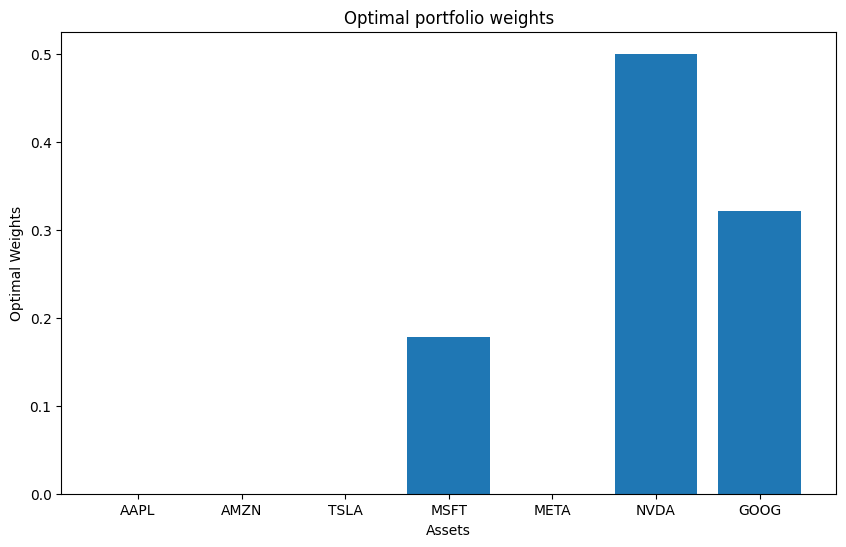

In [46]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.bar(tickers, optimal_weights)

plt.xlabel("Assets")
plt.ylabel("Optimal Weights")
plt.title("Optimal portfolio weights")

plt.show()

In [ ]:
# Your tickers list = investment universe (the menu).

# Weights = how much of your money in each asset.

# Expected return = what the portfolio should earn annually, on average.

# Volatility = risk (standard deviation of returns).

# Covariance matrix = how assets interact (the math behind diversification).

# Sharpe ratio = reward-to-risk tradeoff.

# Optimization = finds the portfolio that maximizes Sharpe, subject to your rules (constraints/bounds).

# Plot = visualization of allocation strategy.